In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import modred as mr
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import DataLoader

from src.models import MLP
from src.solvers.fem import Poisson1D, HelmholtzImpedance1D, ParameterizedSolver
from src.utils.helpers import PairDataset

In [2]:
sns.set_theme()

In [3]:
def get_sol(u, bases):
    assert len(u) == len(bases)
    return lambda x: np.sum([u[i] * bases[i](x) for i in range(len(bases))], axis=0)

def get_der(u, bases):
    assert len(u) == len(bases)
    return lambda x: np.sum([u[i] * bases[i].deriv(1)(x) for i in range(len(bases))], axis=0)

In [4]:
def plot_bases(S, bases):

    xs = np.linspace(-1, 1, 100)
    us = []
    # MODIFY: Combine these two loops
    sols = [get_sol(S[:, j], bases) for j in range(S.shape[1])]
    for idx, sol in enumerate(sols):
        us.append(sol(xs))

    df = pd.DataFrame({
        'x': np.concatenate([xs] * len(us)),
        'u_re': np.concatenate([u.real for u in us]),
        'u_im': np.concatenate([u.imag for u in us]),
        'j': np.concatenate([np.repeat(j, len(xs)) for j in range(len(sols))]),
    })

    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 10))
    sns.lineplot(
        data=df,
        x='x',
        y='u_re',
        hue='j',
        ax=axs[0],
    )
    sns.lineplot(
        data=df,
        x='x',
        y='u_im',
        hue='j',
        ax=axs[1],
    )


In [5]:
def H1_error(e: Callable, e_x: Callable, solver) -> float:

    u2 = lambda x: abs(e(x)) ** 2
    ux2 = lambda x: abs(e_x(x)) ** 2

    err_u = np.sqrt(solver.intg(u2))
    err_u_x = np.sqrt(solver.intg(ux2))

    return err_u + err_u_x, err_u, err_u_x

# Define the solver and get snapshots

In [118]:
N_h = 101

a = [
    (8. * np.pi),
    (3. * np.pi),
    # lambda x: 30,
    # lambda x: x ** 2,
    # lambda x: 1j * 20 * (x ** 4),
    # lambda x: 10 * np.exp(x),
    # lambda x: 10 * np.exp(3 * (x ** 2)),
    # lambda x: 1j * 10 * np.exp(-5 * x),
    # lambda x: 15 * np.sin(x),
    # lambda x: -10 * np.cos(3 * x),
]
M = len(a)

if False:
    solver = HelmholtzImpedance1D(k=(4. * np.pi), ga=10., gb=20., f=None, a=-1., b=+1., N=(N_h-1))
    parsolver = ParameterizedSolver(solver=solver, a=a, uc='f')
elif True:
    solver = HelmholtzImpedance1D(k=None, ga=10., gb=20., f=(lambda x: x), a=-1., b=+1., N=(N_h-1))
    parsolver = ParameterizedSolver(solver=solver, a=a, uc='k')
elif True:
    # NOTE: Solutions are wrong, needs to be checked
    solver = Poisson1D(f=lambda x: np.sin(x), k=None, N=(N_h-1))
    parsolver = ParameterizedSolver(solver=solver, a=a, uc='k')

/Users/sepehr/miniconda3/envs/mcss/lib/python3.10/site-packages/scipy/special/_orthogonal.py:370: RuntimeWarning: invalid value encountered in double_scalars
  hn *= _gam(n + beta + 1.0) / _gam(n + 1) / _gam(n + ab1)
/Users/sepehr/miniconda3/envs/mcss/lib/python3.10/site-packages/scipy/special/_orthogonal.py:371: RuntimeWarning: invalid value encountered in double_scalars
  kn = _gam(2 * n + ab1) / 2.0**n / _gam(n + 1) / _gam(n + ab1)


In [119]:
N_bas = 100
N_trn = 300
N_val = 50


# Basis
y_bas = np.concatenate(
    [
        np.ones(shape=(1, N_bas)),
        2 * np.random.random_sample(size=(M-1, N_bas)) - 1,
    ],
    axis=0,
)
S_bas = parsolver.solve(y=y_bas)

# Train
y_trn = np.concatenate(
    [
        np.ones(shape=(1, N_trn)),
        2 * np.random.random_sample(size=(M-1, N_trn)) - 1,
    ],
    axis=0,
)
S_trn = parsolver.solve(y=y_trn)

# Validation
y_val = np.concatenate(
    [
        np.ones(shape=(1, N_val)),
        2 * np.random.random_sample(size=(M-1, N_val)) - 1,
    ],
    axis=0,
)
S_val = parsolver.solve(y=y_val)

In [120]:
# fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 5))
# sns.boxplot(pd.DataFrame(np.concatenate([y_trn.real, y_trn.imag]).T), ax=axs[0])
# sns.boxplot(pd.DataFrame(np.concatenate([y_val.real, y_val.imag]).T), ax=axs[1])
# axs[0].set(title='train', xlabel='$i$', ylabel='$y_i$')
# axs[1].set(title='validation', xlabel='$i$')

rank(S): 31


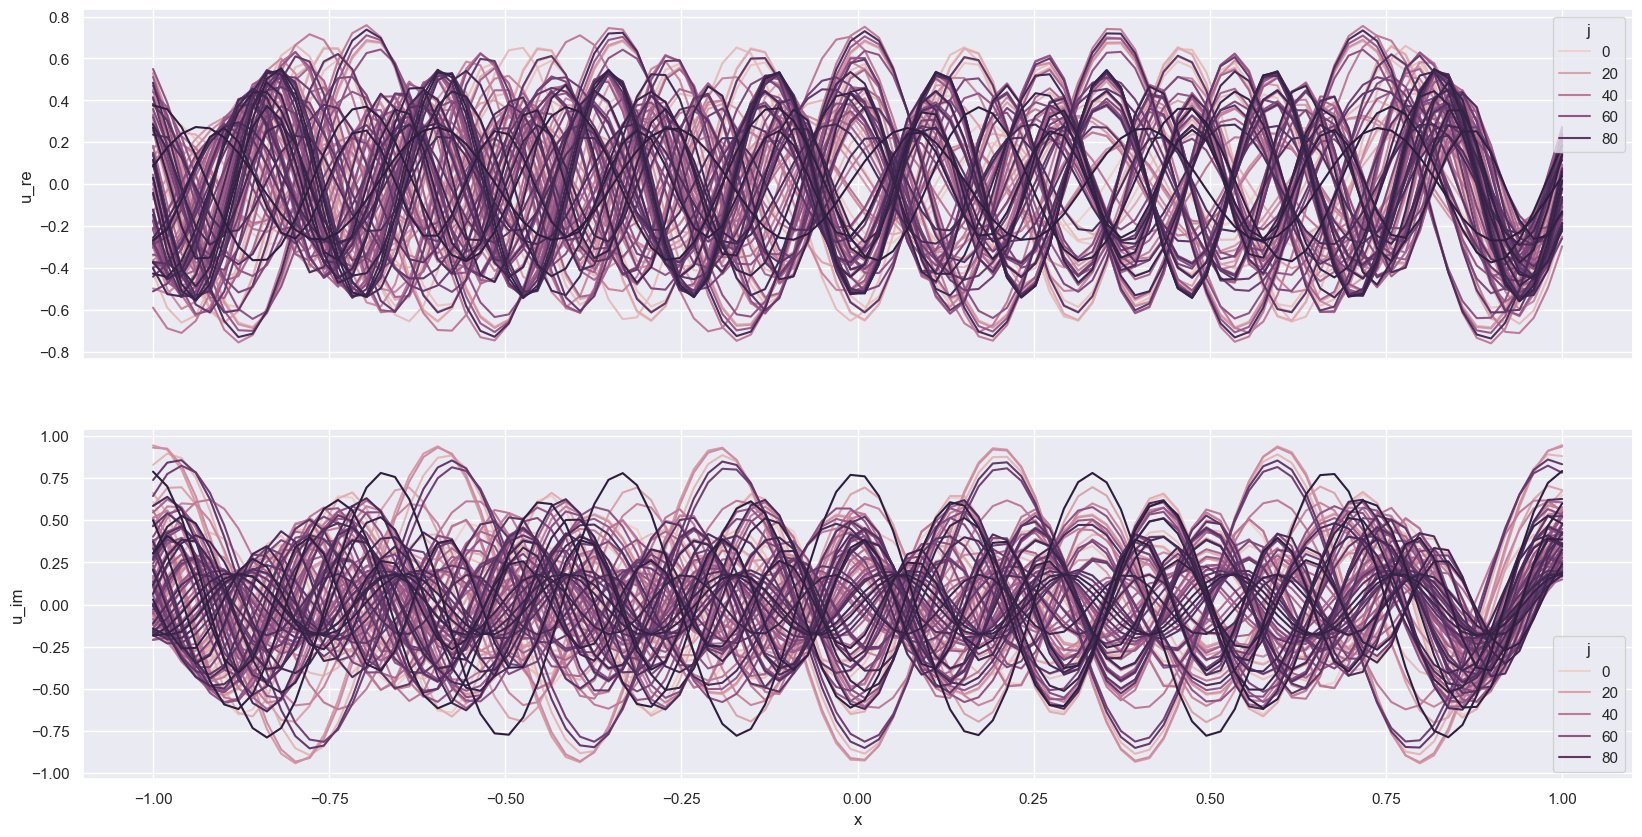

In [121]:
plot_bases(S=S_bas, bases=solver.bases)
print(f'rank(S): {np.linalg.matrix_rank(S_bas)}')

# Train a neural network

In [65]:
L = 10

# Check the dimension of the reduced basis
assert L <= np.linalg.matrix_rank(S_bas)

# Get the reduced basis and the coefficients
pod = mr.compute_POD_arrays_snaps_method(
    S_bas,
    list(mr.range(L))
)
V = pod.modes
c_trn = V.conj().T @ S_trn
c_val = V.conj().T @ S_val

print([f'{eigval:.2e}' for eigval in pod.eigvals[:L]])

['8.63e+02', '3.89e+02', '3.30e+02', '2.85e+02', '2.55e+02', '2.02e+02', '8.90e+01', '2.22e+01', '1.54e+00', '1.06e-01']


MLP with 362 parameters


100%|██████████| 20000/20000 [01:25<00:00, 234.84it/s]


Train: 4.79e-02		Validation: 4.27e+00
H1-error (train): 2.62e+00
H1-error (validation): 3.15e+00


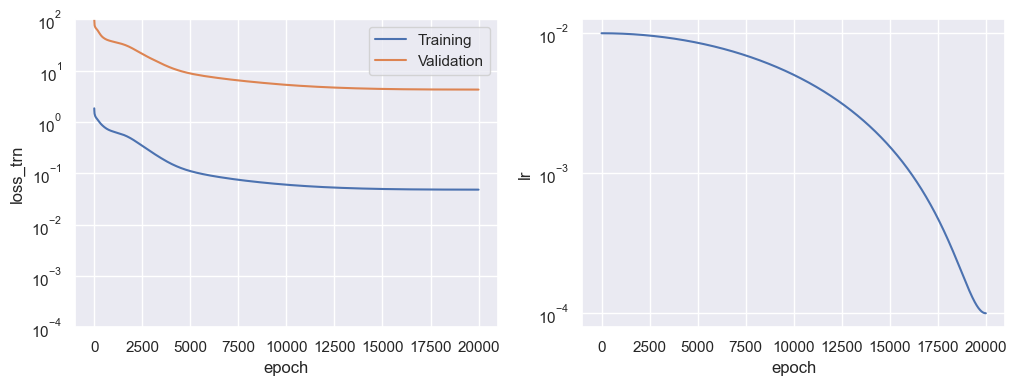

In [39]:
epochs = 20000
lr = 1e-02
wd = 0
bsz = None
batch_norm = False

# Assertion for batch norm
if batch_norm and bsz:
    assert bsz > 1

# Define data loaders
trainloader = DataLoader(
    dataset=PairDataset(y=y_trn, c=c_trn),
    batch_size=(bsz if bsz else y_trn.shape[1]),
    shuffle=True,
    drop_last=batch_norm,
)
validationloader = DataLoader(
    dataset=PairDataset(y=y_val, c=c_val),
    batch_size=1,
    shuffle=False,
)

# Define model, criterion, and optimizer
model = MLP(
    M=M,
    L=(2 * L),  # Real and imaginary parts
    hidden_layers=[10, 10],
    activation=torch.relu,
    gain=1.,
    dtype=torch.float64,
)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=.9, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-04, T_max=epochs)

# Train the model
print(f'{model.__class__.__name__} with {model.numparams()} parameters')
stats = model.train_(
    criterion=criterion,
    epochs=epochs,
    optimizer=optimizer,
    trainloader=trainloader,
    validationloader=validationloader,
    scheduler=scheduler,
    cuda=False,
)

# Clean the stats
params = stats.pop('params')
grads = stats.pop('grads')
stats = pd.DataFrame(stats)

# Plot the training procedure
if True:

    # Plot the training statistics
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    sns.lineplot(stats, x='epoch', y='loss_trn', ax=axs[0], label='Training')
    sns.lineplot(stats, x='epoch', y='loss_val', ax=axs[0], label='Validation')
    axs[0].set(yscale='log', ylim=[1e-04, 1e02])
    axs[0].legend()
    sns.lineplot(stats, x='epoch', y='lr', ax=axs[1])
    axs[1].set(yscale='log')

    # Print the final losses
    print('\t\t'.join([
        f"Train: {stats['loss_trn'].tolist()[-1]:.2e}",
        f"Validation: {stats['loss_val'].tolist()[-1]:.2e}",
    ]))

# Get the outputs
model.eval()
c_trn_out = model(torch.tensor(y_trn.T)).detach().numpy()
c_val_out = model(torch.tensor(y_val.T)).detach().numpy()

# Get the NN solutions and errors
c_trn_ = (c_trn_out[:, :L] + 1j * c_trn_out[:, L:]).T
c_val_ = (c_val_out[:, :L] + 1j * c_val_out[:, L:]).T
S_trn_ = V @ c_trn_
S_val_ = V @ c_val_
E_trn = S_trn - S_trn_
E_val = S_val - S_val_

# Get the mean H1-errors
E = E_trn
H1errs = []
for j in range(E.shape[1]):
    err, err_u, err_u_x = H1_error(
        e=get_sol(u=E[:, j], bases=solver.bases),
        e_x=get_der(u=E[:, j], bases=solver.bases),
        solver=solver,
    )
    H1errs.append(err)
print(f'H1-error (train): {np.array(H1errs).mean():.2e}')
E = E_val
H1errs = []
for j in range(E.shape[1]):
    err, err_u, err_u_x = H1_error(
        e=get_sol(u=E[:, j], bases=solver.bases),
        e_x=get_der(u=E[:, j], bases=solver.bases),
        solver=solver,
    )
    H1errs.append(err)
print(f'H1-error (validation): {np.array(H1errs).mean():.2e}')

## Plot weights, biases, and outputs

In [ ]:
# # Read the parameters and the gradients
# params_ = {}
# grads_ = {}
# for name, vals in params.items():
#     if not model.bn and 'bn' in name:
#         continue
#     params_[name] = {'epoch': [], 'val': []}
#     for e in range(len(stats['epoch'])):
#         val = vals[e].flatten()
#         params_[name]['epoch'].extend([e] * len(val))
#         params_[name]['val'].extend(val)
# for name, vals in grads.items():
#     if not model.bn and 'bn' in name:
#         continue
#     grads_[name] = {'epoch': [], 'val': []}
#     for e in range(len(stats['epoch'])-1):
#         if vals[e] is None:
#             continue
#         val = vals[e].flatten()
#         grads_[name]['epoch'].extend([e] * len(val))
#         grads_[name]['val'].extend(val)
# params = {name: pd.DataFrame(params_[name]) for name in params_.keys()}
# grads = {name: pd.DataFrame(grads_[name]) for name in grads_.keys()}

# # Plot the parameters
# ncols = 2
# nrows = (len(params) + 1) // ncols
# fig, axs = plt.subplots(
#     ncols=ncols,
#     nrows=nrows,
#     figsize=(12, 5 * nrows)
# )
# axs = axs.flatten()

# for idx, (name, df) in enumerate(params.items()):
#     sns.boxplot(
#         data=df[
#             (df['epoch'] % (epochs // 10) == 0)
#             # (df['epoch'] <= 100) & (df['epoch'] % (epochs // 100) == 0)
#         ],
#         x='epoch', y='val',
#         color='blue',
#         showfliers=False,
#         ax=axs[idx],
#     )

#     axs[idx].set(ylabel='', xlabel='', title=name)

# # Plot the gradients
# ncols = 2
# nrows = (len(grads) + 1) // ncols
# fig, axs = plt.subplots(
#     ncols=ncols,
#     nrows=nrows,
#     figsize=(12, 5 * nrows)
# )
# axs = axs.flatten()
# for idx, (name, df) in enumerate(grads.items()):
#     sns.boxplot(
#         data=df[
#             (df['epoch'] % (epochs // 10) == 0)
#             # (df['epoch'] <= 100) & (df['epoch'] % (epochs // 100) == 0)
#         ],
#         x='epoch', y='val',
#         color='green',
#         showfliers=False,
#         ax=axs[idx],
#     )

#     axs[idx].set(ylabel='', xlabel='', title=name)

# # Plot the outputs
# fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
# sns.boxplot(pd.DataFrame(c_trn_out), ax=axs[0])
# sns.boxplot(pd.DataFrame(c_val_out), ax=axs[1])
# fig.suptitle('Distributions')
# axs[0].set(title='train', xlabel='$i$', ylabel='$c_i$')
# axs[1].set(title='validation', xlabel='$i$')

## Plot evaluations

In [ ]:
# # Plot the distributions of the coefficients
# fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 5))
# sns.boxplot(pd.DataFrame(np.concatenate([c_trn.real, c_trn.imag]).T), ax=axs[0])
# sns.boxplot(pd.DataFrame(np.concatenate([c_val.real, c_val.imag]).T), ax=axs[1])
# fig.suptitle('Distributions')
# axs[0].set(title='train', xlabel='$i$', ylabel='$c_i$')
# axs[1].set(title='validation', xlabel='$i$')

# # Plot the error distributions of the coefficients
# fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 5))
# sns.boxplot(pd.DataFrame(np.abs(c_trn - c_trn_).T), ax=axs[0])
# sns.boxplot(pd.DataFrame(np.abs(c_val - c_val_).T), ax=axs[1])
# fig.suptitle('Absolute errors')
# axs[0].set(title='train', xlabel='$i$', ylabel='$c_i$')
# axs[1].set(title='validation', xlabel='$i$')

# # Plot the distributions of the solution matrices
# fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 5))
# sns.boxplot(pd.DataFrame(np.concatenate([S_trn.real, S_trn.imag]).T), ax=axs[0])
# sns.boxplot(pd.DataFrame(np.concatenate([S_val.real, S_val.imag]).T), ax=axs[1])
# fig.suptitle('Distributions')
# axs[0].set(title='train', xlabel='$i$', ylabel='$s_i$')
# axs[1].set(title='validation', xlabel='$i$')

# # Plot the error distributions of the solution matrices
# fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 5))
# sns.boxplot(pd.DataFrame(np.abs(S_trn - S_trn_).T), ax=axs[0])
# sns.boxplot(pd.DataFrame(np.abs(S_val - S_val_).T), ax=axs[1])
# fig.suptitle('Absolute errors')
# axs[0].set(title='train', xlabel='$i$', ylabel='$s_i$')
# axs[1].set(title='validation', xlabel='$i$')

# # Plot the NN validation approximations
# plot_bases(S=S_val_, bases=solver.bases)
# # Plot the NN validation errors
# plot_bases(S=E_val, bases=solver.bases)

# Study convergence

In [122]:
epochs = 20000
lr = 1e-02
wd = 0
bsz = None
batch_norm = False


Ls = list(range(1, 11))

# Check the dimension of the reduced basis
for L in Ls:
    assert L <= np.linalg.matrix_rank(S_bas)

# Train for each L
eigvals = [None] * len(Ls)
errs = {'train': [None] * len(Ls), 'validation': [None] * len(Ls)}
losses = {'train': [None] * len(Ls), 'validation': [None] * len(Ls)}
for idx, L in enumerate(Ls):
    # Print
    print('-' * 50)
    print(f'L = {L}')

    # Get the reduced basis and the coefficients
    pod = mr.compute_POD_arrays_snaps_method(
        S_bas,
        list(mr.range(L))
    )
    V = pod.modes
    eigvals[idx] = pod.eigvals[L-1]
    c_trn = V.conj().T @ S_trn
    c_val = V.conj().T @ S_val

    # Assertion for batch norm
    if batch_norm and bsz:
        assert bsz > 1

    # Define data loaders
    trainloader = DataLoader(
        dataset=PairDataset(y=y_trn, c=c_trn),
        batch_size=(bsz if bsz else y_trn.shape[1]),
        shuffle=True,
        drop_last=batch_norm,
    )
    validationloader = DataLoader(
        dataset=PairDataset(y=y_val, c=c_val),
        batch_size=1,
        shuffle=False,
    )


    for _ in range(3):
        # Define model, criterion, and optimizer
        model = MLP(
            M=M,
            L=(2 * L),  # Real and imaginary parts
            hidden_layers=[10, 10],
            activation=torch.relu,
            gain=1.,
            dtype=torch.float64,
        )
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=.9, weight_decay=wd)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-04, T_max=epochs)

        # Train the model
        print(f'{model.__class__.__name__} with {model.numparams()} parameters')
        stats = model.train_(
            criterion=criterion,
            epochs=epochs,
            optimizer=optimizer,
            trainloader=trainloader,
            validationloader=validationloader,
            scheduler=scheduler,
            cuda=False,
        )

        # Clean the stats
        params = stats.pop('params')
        grads = stats.pop('grads')
        stats = pd.DataFrame(stats)

        # Skip if the validation loss is not smaller than before
        if losses['validation'][idx] and losses['validation'][idx] < stats['loss_val'].tolist()[-1]:
            continue

        # Store the losses
        losses['train'][idx] = stats['loss_trn'].tolist()[-1]
        losses['validation'][idx] = stats['loss_val'].tolist()[-1]

        # Get the outputs
        model.eval()
        c_trn_out = model(torch.tensor(y_trn.T)).detach().numpy()
        c_val_out = model(torch.tensor(y_val.T)).detach().numpy()

        # Get the NN solutions and errors
        c_trn_ = (c_trn_out[:, :L] + 1j * c_trn_out[:, L:]).T
        c_val_ = (c_val_out[:, :L] + 1j * c_val_out[:, L:]).T
        S_trn_ = V @ c_trn_
        S_val_ = V @ c_val_
        E_trn = S_trn - S_trn_
        E_val = S_val - S_val_

        # Get the mean H1-errors
        E = E_trn
        H1errs = []
        for j in range(E.shape[1]):
            err, err_u, err_u_x = H1_error(
                e=get_sol(u=E[:, j], bases=solver.bases),
                e_x=get_der(u=E[:, j], bases=solver.bases),
                solver=solver,
            )
            H1errs.append(err)
        errs['train'][idx] = np.array(H1errs).mean()
        E = E_val
        H1errs = []
        for j in range(E.shape[1]):
            err, err_u, err_u_x = H1_error(
                e=get_sol(u=E[:, j], bases=solver.bases),
                e_x=get_der(u=E[:, j], bases=solver.bases),
                solver=solver,
            )
            H1errs.append(err)
        errs['validation'][idx] = np.array(H1errs).mean()

--------------------------------------------------
L = 1
MLP with 206 parameters


100%|██████████| 20000/20000 [01:24<00:00, 236.02it/s]


MLP with 206 parameters


100%|██████████| 20000/20000 [01:23<00:00, 239.26it/s]


MLP with 206 parameters


100%|██████████| 20000/20000 [01:23<00:00, 238.60it/s]


--------------------------------------------------
L = 2
MLP with 232 parameters


100%|██████████| 20000/20000 [01:23<00:00, 239.01it/s]


MLP with 232 parameters


100%|██████████| 20000/20000 [02:03<00:00, 162.47it/s]


MLP with 232 parameters


100%|██████████| 20000/20000 [01:23<00:00, 239.75it/s]


--------------------------------------------------
L = 3
MLP with 258 parameters


100%|██████████| 20000/20000 [01:23<00:00, 238.38it/s]


MLP with 258 parameters


100%|██████████| 20000/20000 [01:23<00:00, 239.12it/s]


MLP with 258 parameters


100%|██████████| 20000/20000 [01:23<00:00, 238.53it/s]


--------------------------------------------------
L = 4
MLP with 284 parameters


100%|██████████| 20000/20000 [01:23<00:00, 238.59it/s]


MLP with 284 parameters


100%|██████████| 20000/20000 [01:24<00:00, 237.95it/s]


MLP with 284 parameters


100%|██████████| 20000/20000 [01:23<00:00, 238.60it/s]


--------------------------------------------------
L = 5
MLP with 310 parameters


100%|██████████| 20000/20000 [01:24<00:00, 236.87it/s]


MLP with 310 parameters


100%|██████████| 20000/20000 [01:23<00:00, 238.51it/s]


MLP with 310 parameters


100%|██████████| 20000/20000 [01:24<00:00, 237.39it/s]


--------------------------------------------------
L = 6
MLP with 336 parameters


100%|██████████| 20000/20000 [01:24<00:00, 237.84it/s]


MLP with 336 parameters


100%|██████████| 20000/20000 [01:24<00:00, 237.72it/s]


MLP with 336 parameters


100%|██████████| 20000/20000 [01:24<00:00, 237.60it/s]


--------------------------------------------------
L = 7
MLP with 362 parameters


100%|██████████| 20000/20000 [08:56<00:00, 37.28it/s]  


MLP with 362 parameters


100%|██████████| 20000/20000 [01:23<00:00, 238.23it/s]


MLP with 362 parameters


100%|██████████| 20000/20000 [01:24<00:00, 237.29it/s]


--------------------------------------------------
L = 8
MLP with 388 parameters


100%|██████████| 20000/20000 [01:24<00:00, 237.55it/s]


MLP with 388 parameters


100%|██████████| 20000/20000 [01:24<00:00, 237.62it/s]


MLP with 388 parameters


100%|██████████| 20000/20000 [01:24<00:00, 237.34it/s]


--------------------------------------------------
L = 9
MLP with 414 parameters


100%|██████████| 20000/20000 [01:24<00:00, 236.99it/s]


MLP with 414 parameters


100%|██████████| 20000/20000 [01:24<00:00, 237.97it/s]


MLP with 414 parameters


100%|██████████| 20000/20000 [01:24<00:00, 237.66it/s]


--------------------------------------------------
L = 10
MLP with 440 parameters


100%|██████████| 20000/20000 [01:24<00:00, 238.04it/s]


MLP with 440 parameters


100%|██████████| 20000/20000 [01:24<00:00, 236.36it/s]


MLP with 440 parameters


100%|██████████| 20000/20000 [01:24<00:00, 237.71it/s]


In [123]:
errs['validation']

[14.532674938063678,
 12.362928210791326,
 10.451457423273645,
 10.46292514242747,
 11.498880748236582,
 11.420931478941034,
 9.670892700043566,
 8.278229143348469,
 9.626620690405876,
 10.72542040243179]

[None]

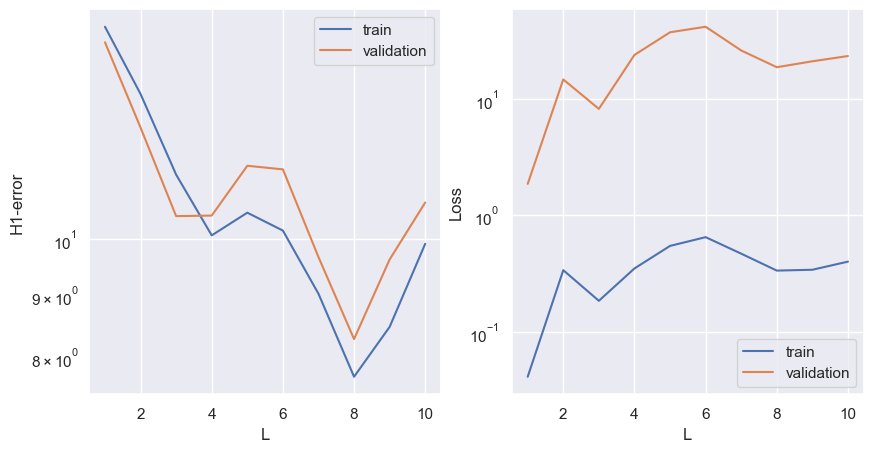

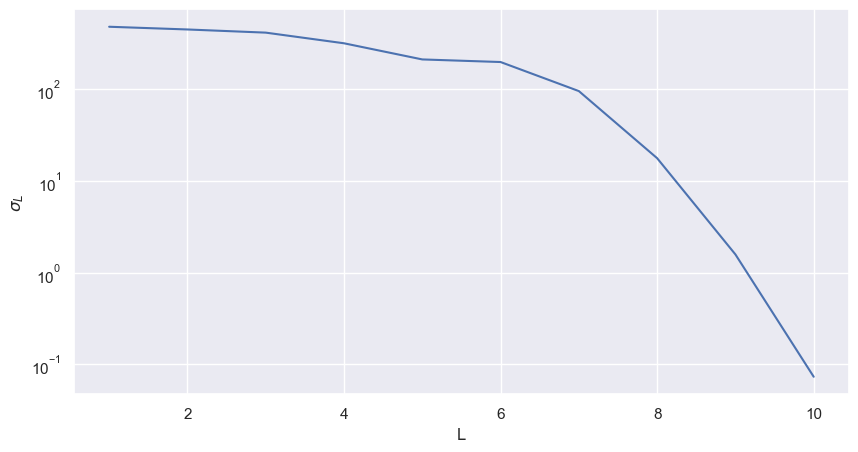

In [124]:
df = pd.DataFrame({
    'L': Ls,
    'eigval': eigvals,
    'train error': errs['train'],
    'validation error': errs['validation'],
    'train loss': losses['train'],
    'validation loss': losses['validation'],
})

# Plot the outputs
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(10, 5))
sns.lineplot(df, x='L', y='train error', label='train', ax=axs[0])
sns.lineplot(df, x='L', y='validation error', label='validation', ax=axs[0])
sns.lineplot(df, x='L', y='train loss', label='train', ax=axs[1])
sns.lineplot(df, x='L', y='validation loss', label='validation', ax=axs[1])
axs[0].set(ylabel='H1-error')
axs[1].set(ylabel='Loss')
for ax in axs:
    ax.set(yscale='log')
    ax.legend()

# Plot the outputs
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(10, 5))
sns.lineplot(df, x='L', y='eigval', ax=ax)
ax.set(ylabel='$\\sigma_L$')
ax.set(yscale='log')